# Home Credit Default Risk Prediction

##### Predicting whether an applicant is capable of repaying a loan or not. 

## 1. Setup shared libraries on path

This setup is done to establish the bridge to use custom libraries.

In [1]:
# Auto - reload libraries

# Run it as the first statement while experimenting with library code
# By default, session needs to be restarted for every change in libraries
# By using this code, it automatically loads the library at run-time when the function is executed

# Keep it commented for normal execution / demo purposes since there is no need for library reload

# %load_ext autoreload
# %autoreload 2

In [2]:
# custom library
from lib.ConfigLib import configDict

In [3]:
# Setup initial configuration
sharedLibPath = configDict['sharedLibPath']

dataPath = configDict['dataPath']
modelPath = configDict['modelPath']

mlFlowUri = configDict['mlFlowUri']

swaggerSpecFilePath = configDict['swaggerSpecFilePath']
swaggerApiPort = configDict['swaggerApiPort']

In [4]:
# custom library
from lib.initShared import initializeSharedLib

In [5]:
# Initialize environment to load custom libraries from shared path
initializeSharedLib(sharedLibPath)

In [6]:
# Import required libraries (modules available on web)
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LogisticRegressionModel
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Import required libraries (custom)
from Data_Cleaning_Lib.CleanLib import DataCleaningLib
from S3serializer_Lib.S3Serializer import S3Bucket
from Feature_Importance_Lib.Feature_Importance import Feature_Importance_Transformer
from Encode_Lib import EncodeLib
from Model_Fit_Lib import Model_Fit
import apilib

## 2. Data Ingestion

### 2.1 Create Spark session

In [7]:
spark = SparkSession.builder.appName('HomeCredit').getOrCreate()

### 2.2 Connect to remote cluster

<b>Connecting to a remote ec2 instance ip:18.212.194.194</b>

In [8]:
s3=S3Bucket()
s3.connect(host = "18.212.194.194", username = "centos", key = dataPath+'InternalPOC_Digital.pem')

Connecting to host  18.212.194.194
Connected


### 2.3 Fetch data from remote cluster

<b>Saving data into Local system<b>

In [9]:
# Assuming that directory exists and that user has read-write-permission on it
s3.get_dir_remote(dataPath+'dataset','home_credit')

Getting data...
Getting File--> part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> _SUCCESS
['part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', '_SUCCESS']


### 2.4 Load data

<b>Loading data into spark for processing</b>

In [10]:
rawData = spark.read.parquet(dataPath+'dataset')

### 2.5 Data Profiling

#### 2.5.1 Numerical column Profiling

In [11]:
import pandas as pd
pd.read_csv(dataPath+'num_profiler.csv')

,Column,type,Null_count,%Null,count,mean,stddev,min,25%,50%,75%,max,Range
0,EXT_SOURCE_1,double,173378,56.38,134133.0,0.50,0.21,0.01,0.33,0.51,0.68,9.600000e-01,['0.01']-['0.96']
1,NONLIVINGAPARTMENTS_MODE,double,213514,69.43,93997.0,0.01,0.05,0.00,0.00,0.00,0.00,1.000000e+00,['0.00']-['1.00']
2,COMMONAREA_AVG,double,214865,69.87,92646.0,0.04,0.08,0.00,0.01,0.02,0.05,1.000000e+00,['0.00']-['1.00']
3,OWN_CAR_AGE,double,202929,65.99,104582.0,12.06,11.94,0.00,5.00,9.00,15.00,9.100000e+01,['0.00']-['91.00']
4,AMT_GOODS_PRICE,double,278,0.09,307233.0,538396.21,369446.46,40500.00,238500.00,450000.00,679500.00,4.050000e+06,['40500.00']-['4050000.00']
5,APARTMENTS_AVG,double,156061,50.75,151450.0,0.12,0.11,0.00,0.06,0.09,0.15,1.000000e+00,['0.00']-['1.00']
6,BASEMENTAREA_MODE,double,179943,58.52,127568.0,0.09,0.08,0.00,0.04,0.07,0.11,1.000000e+00,['0.00']-['1.00']
7,AMT_REQ_CREDIT_BUREAU_MON,double,41519,13.50,265992.0,0.27,0.92,0.00,0.00,0.00,0.00,2.700000e+01,['0.00']-['27.00']
8,LIVINGAREA_AVG,double,154350,50.19,153161.0,0.11,0.11,0.00,0.05,0.07,0.13,1.000000e+00,['0.00']-['1.00']
9,CNT_CHILDREN,int,0,0.00,307511.0,0.42,0.72,0.00,0.00,0.00,1.00,1.900000e+01,['0.00']-['19.00']


#### 2.5.2 Categorical column Profiling

In [12]:
pd.read_csv(dataPath+'cat_profiler.csv')

,Column,type,Null_count,%Null,categories,Non_ASCII,Top_Feature_0,Top_Feature_1,Top_Feature_2,Top_Feature_3,Top_Feature_4
0,NAME_CONTRACT_TYPE,string,0,0.000000,2,0,Revolving loans:29279,Cash loans:278232,NaN,NaN,NaN
1,CODE_GENDER,string,0,0.000000,3,0,XNA:4,M:105059,F:202448,NaN,NaN
2,FLAG_OWN_CAR,string,0,0.000000,2,0,Y:104587,N:202924,NaN,NaN,NaN
3,FLAG_OWN_REALTY,string,0,0.000000,2,0,N:94199,Y:213312,NaN,NaN,NaN
4,NAME_TYPE_SUITE,string,1292,0.420148,8,0,Other_B:1770,Children:3267,"Spouse, partner:11370",Family:40149,Unaccompanied:248526
5,NAME_INCOME_TYPE,string,0,0.000000,8,0,Unemployed:22,State servant:21703,Pensioner:55362,Commercial associate:71617,Working:158774
6,NAME_EDUCATION_TYPE,string,0,0.000000,5,0,Academic degree:164,Lower secondary:3816,Incomplete higher:10277,Higher education:74863,Secondary / secondary special:218391
7,NAME_FAMILY_STATUS,string,0,0.000000,6,0,Widow:16088,Separated:19770,Civil marriage:29775,Single / not married:45444,Married:196432
8,NAME_HOUSING_TYPE,string,0,0.000000,6,0,Office apartment:2617,Rented apartment:4881,Municipal apartment:11183,With parents:14840,House / apartment:272868
9,OCCUPATION_TYPE,string,96391,31.345545,19,0,Managers:21371,Core staff:27570,Sales staff:32102,Laborers:55186,None:96391


## 3. Data Cleansing

###  Data Cleaning library performs the following functions:<br>
1. Removes the column containing highest number (30%) of null values
2. Imputation is first perfromed for categorical columns followed by the numerical ones
3. Imputes the categorical null containing columns with frequent occurring value of the respective column
4. Imputes the categorical null containing columns with the mean of the respective column 
5. The name of imputed features are prefixed with 'imputed_'
6. Returns the final dataframe with reduced columns after performing required deletions and imputations

In [13]:
cln = DataCleaningLib()

In [14]:
data = cln.transform(rawData)

Number of columns in raw dataset :  122
1.Data Cleaning and Preprocessing
2.IMPUTING CATEGORICAL VALUES
3.IMPUTING NUMERICAL VALUES
Number of columns in processed dataset :  72


#### Saving the cleaned data so it can be used for later processes without re-doing the previous steps

In [15]:
data.write.parquet(path=dataPath+'cleaned.parquet', mode='overwrite')

### 3.1 Feature Importance
Feature selection algorithms gives us a high level overview of the features that are affecting the statistical model. In other words this gives us relatively the most important features from our dataset.We can use these features for our final model building task without Overfitting(feeding the model with too many features that can inversely affect the model outcome).
<hr>
Our Feature Importance Library supports the following Implementations
<br>
1. LightGBM<br>
2. CatBoostClassifier<br>
3. RandomForestClassifier<br>
<br>
In the following, we are going to use: <br><b>LightGBM</b> for Feature Importance

In [16]:
#add more

#### Converting cleaned spark data into pandas dataframe for feature selection as lightGBM cannot work on Spark data frame.

In [16]:
data_pandas=data.toPandas()
y=data_pandas['TARGET'].values
data_pandas.drop(['TARGET','SK_ID_CURR'],axis=1,inplace=True)
categorical_columns=set(data_pandas.columns)-set(data_pandas._get_numeric_data().columns)
numeric_columns=data_pandas._get_numeric_data().columns
X=data_pandas[list(numeric_columns)].values

In [17]:
fi = Feature_Importance_Transformer(data_pandas)

#### Why LightGBM
1. lightGBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm
<br>
2. lightGBM supports both categorical and numerical data (unlike random forest which supports only numerical features or chi-sqare which supports only categorical features)
<br>
3. lightGBM is faster than most of the other algorithms(such as Random Forest)

In this library, the threshold value for the number of features to be listed could be specified manually. By default it lists all the features.

Plot Top 40 feature importances…


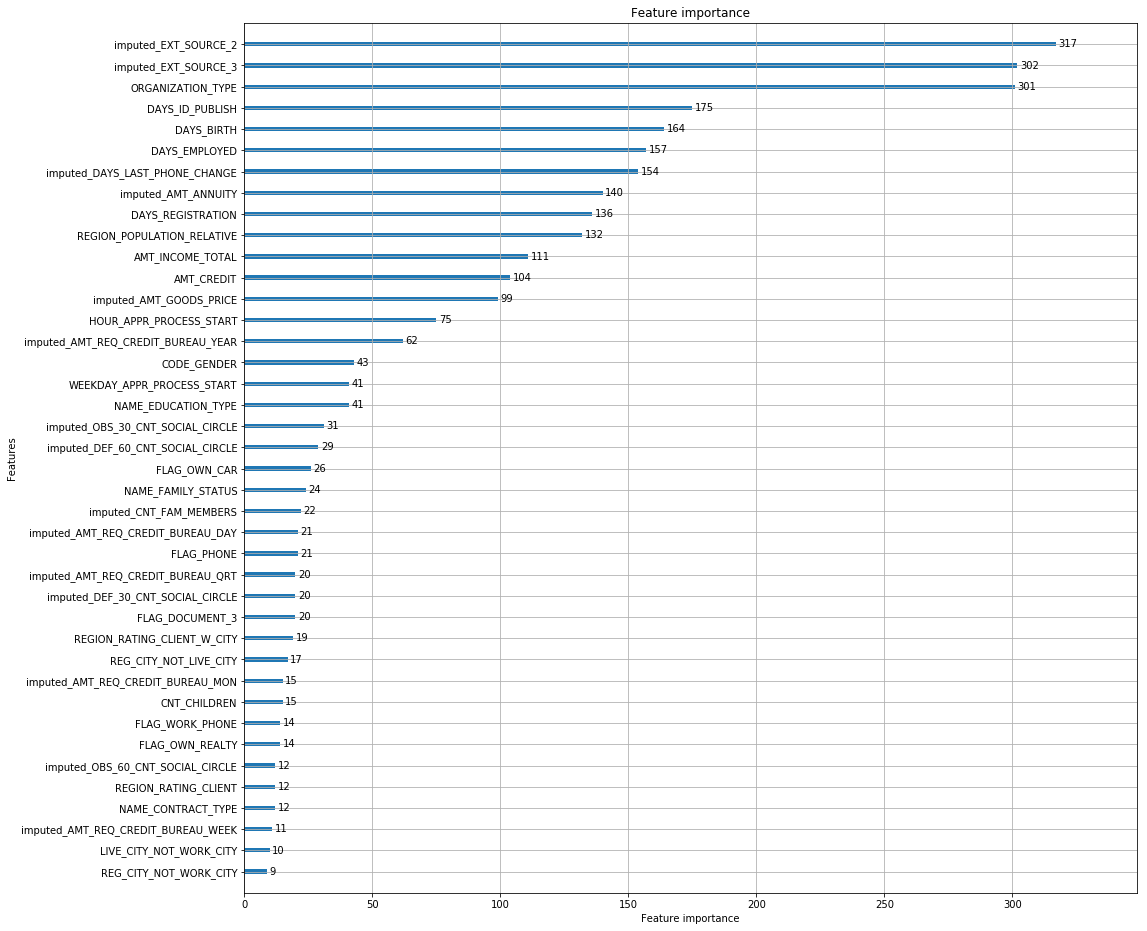

In [18]:
fi.feature_importance_lightGBM(y=y,categorical_columns=categorical_columns,n_features=40)

##### The top 40 features that are of high importance for building the model are listed in order.

### 3.2 Label Encoding


#### Why Label Encoding and  One Hot Encoding?
   Certain algorithms requires numerical values as their predictor variables. Hence Label Encoding or One Hot Encoding becomes necessary. Label Encoding in pyspark is done using StringIndexer class. It gives numerical aliases to different classes
<hr>

#### Our  Label Encoding Library supports the following implementation <br>

1.StringIndexer (spark's native label encoder) needs user to pass in the columns that are to be encoded whereas our library(<b>LabelEncode</b>) takes in only the target/label columns as input.<br>
2.Encodes all the categorical columns in the dataframe and returns the string indexed dataframe.

In [19]:
pp = EncodeLib.LabelEncode()

In [20]:
data = pp.transform(data)

Label Encoding completed.


### 3.3 One Hot Encoding

#### Our Label Encoding Library supports the following implementation <br>
1.OHEncode encodes the Label encoded data as well as determines if the above transformation is necessary.<br>
2.It encodes only if the there are more than 2 distinct categories in a column.(i.e.)other than two catgories<br>
3.The resulting output has the binary vectors appended to the end of each row.<br>

In [21]:
#Why we need OH encoding and what does it mean

In [22]:
ohe = EncodeLib.OHEncode()

In [23]:
data = ohe.transform(data)

One-Hot Encoding completed.


### 3.4 Vector Encode
1.VectorAssembler is used to combine raw features and features generated by different feature transformers into a single vector column named 'features'(vector) which can be used for model building.<br>
2.VectorAssembler accepts the following input column types: all numeric types, boolean type, and vector type.


In [24]:
vec = EncodeLib.VectorChange()

In [25]:
processedData = vec.transform(data)

Vector Encoding completed.


## 4. Model Development 

Our Model_Fit Library supports the following classification algorithms<br> 
1.Logistic regression<br>
2.Random Forest
<hr>

The output of each model would be the ROC value of the respective model.

### 4.1 Obtain train and test datasets

In [26]:
trainData, testData = processedData.randomSplit([0.7,0.3])

### 4.2 Model creation

#### 4.2.1 Create Logistic Regression model

In [27]:
lr_model_raw = LogisticRegression(featuresCol='features', labelCol='TARGET')

In [28]:
lr_model_trained = lr_model_raw.fit(trainData)

#### 4.2 Create Random Forest model

In [29]:
rf_model_raw = RandomForestClassifier(featuresCol='features',labelCol='TARGET')

In [30]:
rf_model_trained = rf_model_raw.fit(trainData)

### 4.3 Model Evaluation

#### 4.3.1 Create Evaluator

In [31]:
binary_eval = BinaryClassificationEvaluator(labelCol='TARGET')

#### 4.3.2 Evaluate Logistic Regression model

In [32]:
predicted = lr_model_trained.transform(testData)

In [33]:
print(binary_eval.evaluate(predicted))

0.740061862338941


#### 4.3.3 Evaluate Random Forest model

In [34]:
predicted = rf_model_trained.transform(testData)

In [35]:
print(binary_eval.evaluate(predicted))

0.7031291732211731


##### From the models applied above, Logistic Regression evaluates better

### 4.4 Model saving

Model is saved in local directory for any future use

In [36]:
lr_model_trained.write().overwrite().save(modelPath+'log_reg.pkl')

### 4.5 Load Model

In [37]:
model = LogisticRegressionModel.load(modelPath+'log_reg.pkl')

### 4.6 Use Model for predictions on processed data sample

In [38]:
# Calculate predictions
predicted = model.transform(testData)

In [39]:
# Show predictions
predicted.select('prediction').show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



## 5. Model Pipeline

### 5.1 Obtain train and test datasets

In [40]:
# trainData, testData = rawData.randomSplit([0.7,0.3])
sampleData = rawData.limit(5)

### 5.1 Create Model Pipeline

In [41]:
cln = DataCleaningLib()
pp = EncodeLib.LabelEncode()
ohe = EncodeLib.OHEncode()
vec = EncodeLib.VectorChange()
lr_model_raw = LogisticRegression(featuresCol='features', labelCol='TARGET')

In [42]:
pipeline = Pipeline(stages=[cln, pp, ohe, vec, lr_model_raw])

In [43]:
pipelineModel = pipeline.fit(sampleData)

Number of columns in raw dataset :  122
1.Data Cleaning and Preprocessing
2.IMPUTING CATEGORICAL VALUES
3.IMPUTING NUMERICAL VALUES
Number of columns in processed dataset :  72
Label Encoding completed.
One-Hot Encoding completed.
Vector Encoding completed.


### 5.2 Save Model Pipeline

In [44]:
pipelineModelPath = modelPath+'pipelineModel'
pipelineModel.write().overwrite().save(pipelineModelPath)

### 5.3 Load Model Pipeline

In [45]:
pipelineModelPath = modelPath+'pipelineModel'
model = PipelineModel.load(pipelineModelPath)

### 5.4 Use Model Pipeline for predictions on data sample

In [46]:
# Calculate predictions
predicted = model.transform(sampleData)

Number of columns in raw dataset :  122
1.Data Cleaning and Preprocessing
2.IMPUTING CATEGORICAL VALUES
3.IMPUTING NUMERICAL VALUES
Number of columns in processed dataset :  72
Label Encoding completed.
One-Hot Encoding completed.
Vector Encoding completed.


In [47]:
# Display predictions
predicted.select('prediction').show()

+----------+
|prediction|
+----------+
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+



## 6. API Deployment

In [7]:
# Swagger UI becomes available after running API on URL http://<serverUrl>:mappedPort/ui
# mappedPort is port mapped as per nginx configuration
# For port 8000, mappedPort is 9390, thus URL is http://34.198.60.96:9390/ui/

# Run API
apilib.api_run(swaggerSpecFilePath, swaggerApiPort)

# To stop the API, interrupt the cell (using button provided) or shutdown notebook (using Notebook interface)

 * Running on http://0.0.0.0:8000/ (Press CTRL+C to quit)
127.0.0.1 - - [16/Jan/2019 18:13:45] "GET /ui/ HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:45] "GET /ui/css/typography.css HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/css/reset.css HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/lib/object-assign-pollyfill.js HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/css/screen.css HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/lib/jquery.slideto.min.js HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/lib/jquery-1.8.0.min.js HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/lib/jquery.wiggle.min.js HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/lib/jquery.ba-bbq.min.js HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/lib/handlebars-4.0.5.js HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "GET /ui/lib/lodash.min.js HTTP/1.0" 200 -
127.0.0.1 - - [16/Jan/2019 18:13:46] "

127.0.0.1 - - [16/Jan/2019 18:14:08] "POST /predictions HTTP/1.0" 500 -


Click <a href = "http://34.198.60.96:9390/ui/" target='_blank'>here</a> to display the Swagger UI.

## -- End-of-notebook --